Episode 1 finished with reward -64.13580246913662
Episode 2 finished with reward -55.655737704919
Episode 3 finished with reward -61.25766871165737
Episode 4 finished with reward -58.23529411764799
Episode 5 finished with reward -57.962962962963964
Episode 6 finished with reward -56.40350877193073
Episode 7 finished with reward -47.20588235294206
Episode 8 finished with reward -58.41463414634235
Episode 9 finished with reward -61.99669966996792
Episode 10 finished with reward -64.1358024691367
Episode 11 finished with reward -53.90410958904189
Episode 12 finished with reward -58.33333333333431
Episode 13 finished with reward -51.36363636363728
Episode 14 finished with reward -61.76737160120939
Episode 15 finished with reward -59.169381107492754
Episode 16 finished with reward -55.573476702509815
Episode 17 finished with reward -53.015267175573356
Episode 18 finished with reward -57.96296296296386
Episode 19 finished with reward -53.3333333333343
Episode 20 finished with reward -51.3636

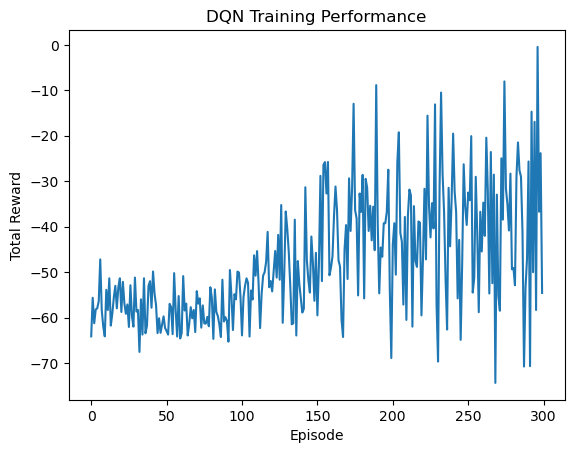

In [ ]:
# DQN_PYTORCH.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import random
import cv2
from collections import deque
import matplotlib.pyplot as plt

# --- Hyperparameters ---
DEVICE = torch.device("cuda")
IMG_SIZE = 96
FRAME_STACK = 1  # You can increase this if you want to stack frames
BUFFER_SIZE = 100_000
BATCH_SIZE = 64
GAMMA = 0.5
ALPHA = 0.1
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQ = 1000
CROP_HEIGHT_PERCENTAGE = 0.12

# --- Preprocessing ---
def preprocess(image):
    image = image[:int(image.shape[0] * (1-CROP_HEIGHT_PERCENTAGE)), :, :]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

# --- Skip Frames ---
def skip_frames(env, skip=50):
    for _ in range(skip):
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)
    return obs

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return s, a, r, s2, d

    def ready(self, batch_size):
        return len(self.buffer) >= batch_size

# --- CNN Model ---
class DQNCNN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        c, h, w = input_shape
        # Define conv layers first
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
        )
        # Compute conv output size
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            conv_out_size = self.conv(dummy).view(1, -1).size(1)
        # Now define the full network
        self.net = nn.Sequential(
            self.conv,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512), nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        return self.net(x)

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, input_shape, num_actions, alpha=ALPHA, gamma=GAMMA,
                 epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY,
                 batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, target_update_freq=TARGET_UPDATE_FREQ):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.steps = 0

        self.policy_net = DQNCNN(input_shape, num_actions).to(DEVICE)
        self.target_net = DQNCNN(input_shape, num_actions).to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)
        self.buffer = ReplayBuffer(buffer_size)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)  # NHWC -> NCHW
        return q_values.argmax(1).item()

    def store_experience(self, experience):
        self.buffer.add(experience)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

    def train(self):
        if not self.buffer.ready(self.batch_size):
            return
        s, a, r, s2, d = self.buffer.sample(self.batch_size)
        # Convert to tensors
        states = torch.tensor(s, dtype=torch.float32, device=DEVICE)
        next_states = torch.tensor(s2, dtype=torch.float32, device=DEVICE)
        if states.ndim == 3:
            states = states.unsqueeze(1)   
            next_states = next_states.unsqueeze(1)
        actions = torch.tensor(a, dtype=torch.int64, device=DEVICE)
        rewards = torch.tensor(r, dtype=torch.float32, device=DEVICE)
        dones = torch.tensor(d, dtype=torch.float32, device=DEVICE)

        # Q(s, a)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        # max_a' Q_target(s', a')
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.update_target_network()

    def run_episode(self, env):
        obs, _ = env.reset()
        obs = skip_frames(env)
        state = preprocess(obs)
        done, total_reward = False, 0

        while not done:
            action = self.select_action(state)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            # modifying the reward function to not get exited when getting huge
            # reward = np.clip(reward,a_min=np.NINF, a_max=1.0)
            done = terminated or truncated
            next_state = preprocess(next_obs)
            self.store_experience((state, action, reward, next_state, float(done)))
            self.train()
            state = next_state
            total_reward += reward

        self.decay_epsilon()
        return total_reward

# --- Main Training Loop ---
def main():
    num_episodes = 300
    env = gym.make("CarRacing-v3", continuous=False)
    action_space = env.action_space.n
    state_space = (1, IMG_SIZE, IMG_SIZE)
    agent = DQNAgent(state_space, action_space)

    rewards = []
    for episode in range(num_episodes):
        total_reward = agent.run_episode(env)
        rewards.append(total_reward)
        print(f"Episode {episode + 1} finished with reward {total_reward}")

        # Save every 50 episodes
        if (episode + 1) % 50 == 0:
            checkpoint_path = f"torch_weights/dqn_policy_weights_ep{episode+1}.pth"
            torch.save(agent.policy_net.state_dict(), checkpoint_path)
            print(f"Saved model weights to {checkpoint_path}")

    checkpoint_path = f"torch_weights/dqn_policy_weights_final.pth"
    torch.save(agent.policy_net.state_dict(), checkpoint_path)
    print(f"Saved model weights to {checkpoint_path}")

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Performance")
    plt.show()

if __name__ == "__main__":
    main()